In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import page_trend_test
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from statannotations.Annotator import Annotator

In [90]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES_PANCAN = "../data/datasets/driver_genes_intogen/Pancancer.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
CLINICAL_DATA = "../data/datasets/PCAWG/clinical_data/pcawg_donor_clinical_data.csv"
SURVIVAL_DATA = "../data/datasets/TCGA/TCGA_survival_outcome.csv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/ directories
RESULTS_DIR = "../results/PCAWG"
OS_PANCAN_GENE = "../results/PCAWG/OS_pancancer"
PLOT_DATA_DIR = "../plot_data/OS_pancancer"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OS_PANCAN_GENE, exist_ok=True)
os.makedirs(PLOT_DATA_DIR, exist_ok=True)
    
CANCER_TYPES = os.listdir(ANNOTATED_MUTATIONS) # all cancer types
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

37 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Lymph-NOS', 'Myeloid-MPN', 'Cervix-AdenoCA', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Bone-Cart', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Epith', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Breast-DCIS', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Myeloid-MDS', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [91]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [92]:
pancan_driver_genes = pd.read_csv(DRIVER_GENES_PANCAN, sep="\t")
pancan_driver_genes = pancan_driver_genes[["Symbol", "Samples (%)"]]
pancan_driver_genes = pancan_driver_genes[pancan_driver_genes["Samples (%)"] >= 1]
print(pancan_driver_genes.shape)
driver_genes_list = pancan_driver_genes["Symbol"].tolist()

(31, 2)


In [93]:
# get all mutations in driver genes
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	tumor_mut_cancer_df["cancer_type"] = cancer_type
	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], ignore_index=True)

# filter for driver genes
print(tumor_mut_df.shape)
tumor_mut_df = tumor_mut_df[tumor_mut_df["gene"].isin(driver_genes_list)]
print(tumor_mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3764334807.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3764334807.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3764334807.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3764334807.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  

(52663963, 14)
(160040, 14)


In [94]:
print(tumor_mut_df.shape)
# filter out samples that are not in the whitelist
tumor_mut_df = tumor_mut_df[tumor_mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(tumor_mut_df.shape)

(160040, 14)
(142168, 14)


In [95]:
# get genome-wide mutation data
genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")[["Tumor_Sample_Barcode", "total_mutations", "cna_burden"]]
tumor_mut_df = pd.merge(tumor_mut_df, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
tumor_mut_df["TMB"] = tumor_mut_df["total_mutations"] * 1e6 / (3.2 * 1e9) # mutations/Mb for 3.2 Gb genome size
tumor_mut_df["TMB_group"] = pd.cut(tumor_mut_df["TMB"], bins=[0, 5, 10, np.inf], labels=["Low (0-5/Mb)", "Medium (5-10/Mb)", "High (>=10/Mb)"])
print(tumor_mut_df.shape)

(142168, 18)


In [96]:
# get clinical data
clinical_data_df = pd.read_csv(CLINICAL_DATA)
clinical_data_df = clinical_data_df[["icgc_donor_id", "submitted_donor_id", "donor_sex"]]
clinical_data_df = clinical_data_df.rename(columns={
    "icgc_donor_id": "Patient_ID", 
    "submitted_donor_id": "bcr_patient_barcode"
})
clinical_data_df.dropna(inplace=True)
clinical_data_df.drop_duplicates(inplace=True)
print(clinical_data_df.shape)

(2809, 3)


In [97]:
# get survival outcomes data
survival_data_df = pd.read_csv(SURVIVAL_DATA)
survival_data_df.reset_index(inplace=True)
survival_data_df.drop(columns=["index", "Unnamed: 0"], inplace=True)
print(survival_data_df.shape)

# merge tumor data with clinical data
tumor_data_merged_df = pd.merge(tumor_mut_df, clinical_data_df, on="Patient_ID", how="left")
print(tumor_data_merged_df.shape)

# merge tumor data with survival data
tumor_survival_data_merged_df = pd.merge(tumor_data_merged_df, survival_data_df, on="bcr_patient_barcode", how="left")
print(tumor_survival_data_merged_df.shape)

(11160, 33)
(142168, 20)


(142168, 52)


## Overall Survival (OS) analysis

In [98]:
# tumor samples for which we have survival data
tumor_survival_data_merged_df.dropna(subset=["OS", "OS.time"], inplace=True)
print(tumor_survival_data_merged_df.shape)

# mutation density by driver status
tumor_OS_df = tumor_survival_data_merged_df[["Tumor_Sample_Barcode", "gene", "mutation", "driver", "has_driver", "OS", "OS.time", "cancer_type", "TMB", "TMB_group", "cna_burden"]]
tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)
tumor_OS_mut_density = tumor_OS_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "mutation": "count",
    "OS": "first",
    "OS.time": "first",
    "cancer_type": "first",
    "TMB_group": "first",
    "cna_burden": "first"
}).reset_index()
tumor_OS_mut_density.rename(columns={"mutation": "mutation_count"}, inplace=True)
print(tumor_OS_mut_density.shape)
tumor_OS_mut_density = tumor_OS_mut_density[tumor_OS_mut_density["has_driver"] != "Passengers in presence of driver"]
print(tumor_OS_mut_density.shape)

(74166, 52)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/2519051491.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")


(8394, 9)
(8094, 9)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/2519051491.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_OS_df["has_driver"] = tumor_OS_df.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)


In [99]:
# list of all tumor samples for which we have survival data
tumor_list = tumor_OS_mut_density["Tumor_Sample_Barcode"].unique().tolist()
print(f"Number of tumor samples for which we have survival data: {len(tumor_list)}")

# list of all genes
gene_list = tumor_OS_mut_density["gene"].unique().tolist()
print(f"Number of genes: {len(gene_list)}")

# create a map of survival data for each tumor
tumor_survival_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_survival_map[row["Tumor_Sample_Barcode"]] = {
        "OS": row["OS"],
        "OS.time": row["OS.time"]
    }
print(len(tumor_survival_map), tumor_survival_map)

# create a map of mutation counts for each tumor-gene-has_driver combination
tumor_gene_has_driver_map = {}
for index, row in tumor_OS_mut_density.iterrows():
    tumor_gene_has_driver_map[(row["Tumor_Sample_Barcode"], row["gene"], row["has_driver"])] = {
        "mutation_count": row["mutation_count"]
    }
print(len(tumor_gene_has_driver_map), tumor_gene_has_driver_map)

Number of tumor samples for which we have survival data: 790
Number of genes: 31
790 {'00493087-9d9d-40ca-86d5-936f1b951c93': {'OS': 0.0, 'OS.time': 1201.0}, '007aab66-2f07-459d-8952-3041d6ea24a8': {'OS': 0.0, 'OS.time': 1148.0}, '00aa769d-622c-433e-8a8a-63fb5c41ea42': {'OS': 0.0, 'OS.time': 255.0}, '00bf0350-8c7c-4b9e-8143-13ea2dc1122f': {'OS': 0.0, 'OS.time': 617.0}, '00db4dc2-3ec7-4ff9-9233-d69c8c8a607f': {'OS': 0.0, 'OS.time': 776.0}, '01658141-8398-4585-9f0f-8355dd9b0604': {'OS': 0.0, 'OS.time': 1925.0}, '0176cf1d-0760-4769-a493-277f4bb7585e': {'OS': 1.0, 'OS.time': 303.0}, '0192d529-7340-45d8-a5f0-249cbb11ca19': {'OS': 0.0, 'OS.time': 531.0}, '020fab36-c7de-4933-b2bf-dc7b019a1326': {'OS': 0.0, 'OS.time': 842.0}, '02c6a893-49c5-49d1-8eb1-195021e70d52': {'OS': 0.0, 'OS.time': 1521.0}, '0332b017-17d5-4083-8fc4-9d6f8fdbbbde': {'OS': 0.0, 'OS.time': 470.0}, '0385961e-ea99-40b2-ad79-6872bc30d8a1': {'OS': 0.0, 'OS.time': 2554.0}, '03c88506-d72e-4a44-a34e-a7f0564f1799': {'OS': 1.0, 'OS.t

In [100]:
tumor_gene_driver_data = []
for tumor in tumor_list:
    cancer_type = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
    tmb_group = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["TMB_group"].values[0]
    cna_burden = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["cna_burden"].values[0]
    for gene in gene_list:
        if (tumor, gene, "Drivers") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type,
                "TMB_group": tmb_group,
                "cna_burden": cna_burden
            })
        elif (tumor, gene, "Passengers in absence of driver") in tumor_gene_has_driver_map:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has passengers but no drivers",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type,
                "TMB_group": tmb_group,
                "cna_burden": cna_burden
            })
        else:
            tumor_gene_driver_data.append({
                "Tumor_Sample_Barcode": tumor,
                "gene": gene,
                "mutation_status": "Has no mutations",
                "OS": tumor_survival_map[tumor]["OS"],
                "OS.time": tumor_survival_map[tumor]["OS.time"],
                "cancer_type": cancer_type,
                "TMB_group": tmb_group,
                "cna_burden": cna_burden
            })
tumor_gene_driver_data = pd.DataFrame(tumor_gene_driver_data)
print(tumor_gene_driver_data.shape)

(24490, 8)


## Pancancer Analysis

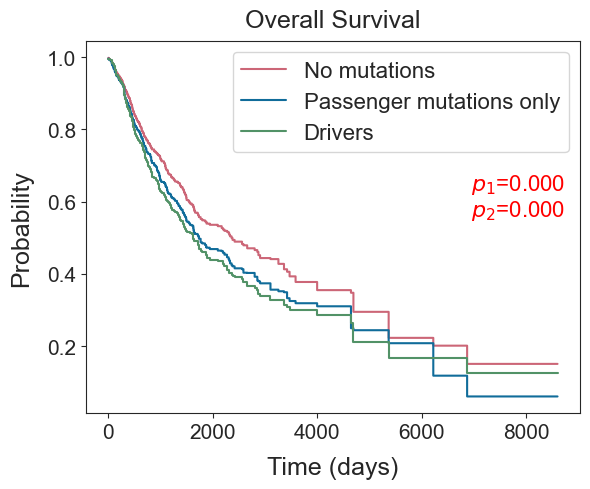

In [101]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_driver_data.copy()

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(6, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has passengers but no drivers"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.6, rf"$\it{{p}}_1$={p_value1:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.53, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=16, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=18)
plt.xlabel('Time (days)', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/overall_survival.png", dpi=300)

# source data
tumor_gene_has_driver_data_selected[["OS", "OS.time", "mutation_status"]].to_csv(f"{PLOT_DATA_DIR}/overall_survival.tsv", sep="\t", index=False)

## Analysis for Tumor Supressor Genes and Oncogenes

In [102]:
tumor_gene_type_driver_data = tumor_gene_driver_data.copy()
def get_cancer_gene_type(is_oncogene, is_tsg):
    if is_oncogene == "Yes" and is_tsg == "No":
        return "OG"
    elif is_oncogene == "No" and is_tsg == "Yes":
        return "TSG"
    elif is_oncogene == "Yes" and is_tsg == "Yes":
        return "Both"
    else:
        return "Neither"

cancer_gene_type = pd.read_csv(CANCER_GENE_TYPES, sep="\t")
cancer_gene_type["type"] = cancer_gene_type.apply(lambda x: get_cancer_gene_type(x["Is Oncogene"], x["Is Tumor Suppressor Gene"]), axis=1)
cancer_gene_type = cancer_gene_type[["Hugo Symbol", "type"]]
cancer_gene_type.columns = ["gene", "type"]
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data = pd.merge(tumor_gene_type_driver_data, cancer_gene_type, on="gene", how="left")
print(tumor_gene_type_driver_data.shape)
tumor_gene_type_driver_data.head()

(24490, 8)
(24490, 9)


,Tumor_Sample_Barcode,gene,mutation_status,OS,OS.time,cancer_type,TMB_group,cna_burden,type
0,00493087-9d9d-40ca-86d5-936f1b951c93,BRAF,Has passengers but no drivers,0.0,1201.0,CNS-Oligo,Low (0-5/Mb),17.32418,OG
1,00493087-9d9d-40ca-86d5-936f1b951c93,CSMD3,Has passengers but no drivers,0.0,1201.0,CNS-Oligo,Low (0-5/Mb),17.32418,NaN
2,00493087-9d9d-40ca-86d5-936f1b951c93,EGFR,Has passengers but no drivers,0.0,1201.0,CNS-Oligo,Low (0-5/Mb),17.32418,OG
3,00493087-9d9d-40ca-86d5-936f1b951c93,FAT3,Has passengers but no drivers,0.0,1201.0,CNS-Oligo,Low (0-5/Mb),17.32418,NaN
4,00493087-9d9d-40ca-86d5-936f1b951c93,IDH1,Has drivers,0.0,1201.0,CNS-Oligo,Low (0-5/Mb),17.32418,OG


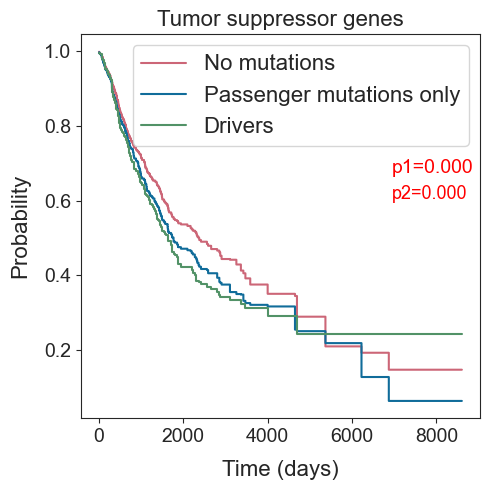

In [103]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "TSG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has passengers but no drivers"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.64, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color2 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.57, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color2)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Tumor suppressor genes", fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/overall_survival_TSG.png", dpi=300)

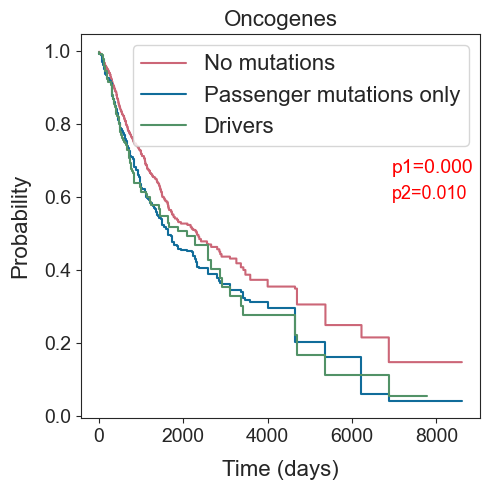

In [104]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_gene_type_driver_data[tumor_gene_type_driver_data["type"] == "OG"]

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(5, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers but no drivers"
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has passengers but no drivers"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.64, f"p1={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=14, color=color1)

# "no mutations" vs "drivers"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"] == "Has drivers"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color2 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.57, f"p2={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=13, color=color2)

plt.ylabel('Probability', labelpad=10, fontsize=16)
plt.xlabel('Time (days)', labelpad=10, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Oncogenes", fontsize=16)
plt.tight_layout()
plt.legend(fontsize=16, loc='upper right')
plt.savefig(f"{RESULTS_DIR}/overall_survival_OG.png", dpi=300)

## Median survival across all genes

In [105]:
results = []
groups = [["Has no mutations"],
		["Has passengers but no drivers"],
		["Has drivers"]]
labels = ["No mutations", "Passenger mutations only", "Drivers"]

# get max duration
max_time = 0

for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = tumor_gene_driver_data[tumor_gene_driver_data["gene"] == gene]
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["mutation_status"].isin(group)]
		max_time = max(max_time, group_df["OS.time"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["OS.time"], group_df["OS"], label='No mutations')
		median = kmf.median_survival_time_
		results.append({
			'gene': gene,
			'group': labels[i],
			'median_survival': median,
			'type': tumor_gene_type_driver_data[tumor_gene_type_driver_data["gene"] == gene]["type"].values[0],
		})
results_df = pd.DataFrame(results)
results_df['median_survival'] = results_df['median_survival'].replace(np.inf, max_time)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No mutations vs. Passenger mutations only: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:7.593e-08 U_stat=8.535e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3465232369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3465232369.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.boxplot(


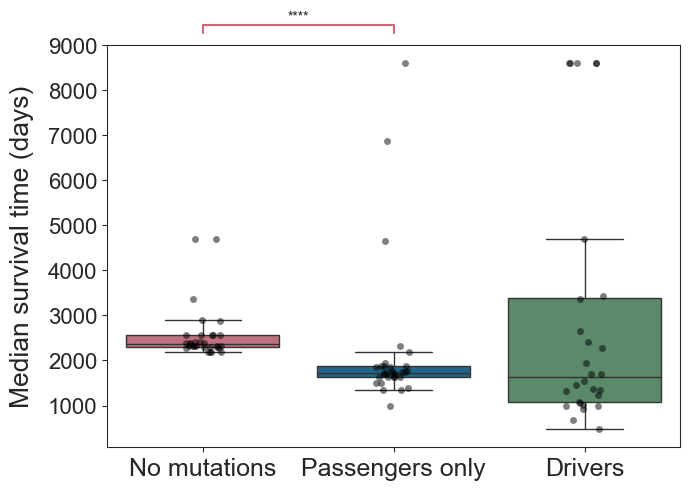

In [107]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=results_df, 
    x='group', 
    y='median_survival',
    order=labels,
    showfliers=False,
    palette=cmap,
)
sns.stripplot(
	data=results_df, 
	x='group', 
	y='median_survival',
	order=labels,
	color='black',
	alpha=0.5,
	size=5,
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=results_df, 
    x="group",
    y="median_survival", 
    pairs=[(labels[0], labels[1]), (labels[1], labels[2])],
    order=labels,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(ticks=[0, 1, 2], \
	labels=["No mutations", "Passengers only", "Drivers"], fontsize=18)
plt.xlabel('')
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=19, labelpad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/median_survival.png", dpi=300)

# source data
results_df[["group", "median_survival"]].to_csv(f"{PLOT_DATA_DIR}/median_survival.tsv", sep="\t", index=False)

## Association of CNA burden and Survival

In [108]:
df_model = (
    tumor_gene_driver_data[
        ["Tumor_Sample_Barcode", "OS.time", "OS", "cna_burden"]
    ]
    .drop_duplicates("Tumor_Sample_Barcode")
    .dropna()
)
print(df_model["cna_burden"].mean(), df_model["cna_burden"].std())

# scale CNA burden for interpretability
df_model["cna_10pct"] = df_model["cna_burden"] / 10.0

# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(
    df_model[["OS.time", "OS", "cna_10pct"]],
    duration_col="OS.time",
    event_col="OS"
)

cph.print_summary()

51.125506137403015 35.064396819996176


<lifelines.CoxPHFitter: fitted with 790 total observations, 496 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 790
number of events observed = 294
   partial log-likelihood = -1721.77
         time fit was run = 2026-01-12 21:22:43 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cna_10pct  0.05      1.05      0.02            0.01            0.08                1.01                1.08

           cmp to    z    p  -log2(p)
covariate                            
cna_10pct    0.00 2.74 0.01      7.34
---
Concordance = 0.55
Partial AIC = 3445.54
log-likelihood ratio test = 7.51 on 1 df
-log2(p) of ll-ratio test = 7.35

In [109]:
hr = np.exp(cph.params_["cna_10pct"])
ci = np.exp(cph.confidence_intervals_.loc["cna_10pct"])
p_value = cph.summary.loc["cna_10pct", "p"]

print(f"HR (per 10% increase in CNA burden): {hr:.2f}")
print(f"95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")
print(f"p-value: {p_value:.3e}")

HR (per 10% increase in CNA burden): 1.05
95% CI: [1.01, 1.08]
p-value: 6.188e-03


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3453458493.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")


## Survival Analysis by number of passenger mutations

In [110]:
missing_rows = []
print(tumor_OS_mut_density.shape)
for tumor in tumor_list:
	cancer_type = tumor_OS_mut_density[tumor_OS_mut_density["Tumor_Sample_Barcode"] == tumor]["cancer_type"].values[0]
	tmb_group = tumor_survival_data_merged_df[tumor_survival_data_merged_df["Tumor_Sample_Barcode"] == tumor]["TMB_group"].values[0]
	if not isinstance(tmb_group, str):
		print(tumor)
	for gene in gene_list:
		if tumor_OS_mut_density[(tumor_OS_mut_density["Tumor_Sample_Barcode"] == tumor) & (tumor_OS_mut_density["gene"] == gene)].shape[0] == 0:
			missing_rows.append({
				"Tumor_Sample_Barcode": tumor,
				"gene": gene,
				"has_driver": "Has no mutations",
				"OS": tumor_survival_map[tumor]["OS"],
				"OS.time": tumor_survival_map[tumor]["OS.time"],
				"cancer_type": cancer_type,
				"TMB_group": tmb_group
			})
missing_rows = pd.DataFrame(missing_rows)
print(len(missing_rows))
tumor_OS_mut_density = pd.concat([tumor_OS_mut_density, missing_rows], ignore_index=True)
print(tumor_OS_mut_density.shape)

(8094, 9)
16396
(24490, 9)


In [111]:
gene_data = tumor_OS_mut_density[tumor_OS_mut_density["has_driver"] == "Passengers in absence of driver"]
gene_data = gene_data[["gene", "mutation_count"]]
gene_data = gene_data.groupby("gene").agg({
	"mutation_count": lambda x: list(x)
}).reset_index()
gene_data["quartlies"] = gene_data["mutation_count"].apply(lambda x: np.percentile(x, [0, 25, 50, 75, 100]))

In [112]:
def get_quartile(row):
	if row["has_driver"] == "Drivers" or row["has_driver"] == "Has no mutations":
		return row["has_driver"]
	gene = row["gene"]
	mutation_count = row["mutation_count"]
	gene_quartiles = gene_data[gene_data["gene"] == gene]["quartlies"].values[0]
	if mutation_count <= gene_quartiles[1]:
		return "Low"
	elif mutation_count > gene_quartiles[1] and mutation_count <= gene_quartiles[3]:
		return "Medium"
	else:
		return "High"

tumor_OS_mut_density["group"] = tumor_OS_mut_density.apply(lambda x: get_quartile(x), axis=1)

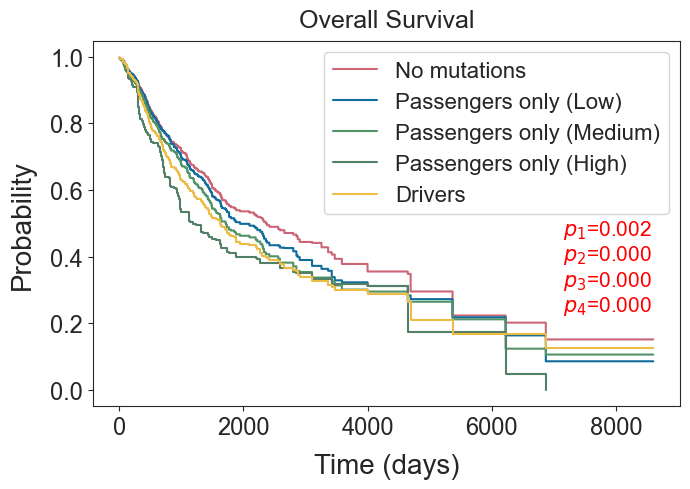

In [113]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#528067", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

tumor_gene_has_driver_data_selected = tumor_OS_mut_density.copy()

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(7, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Has no mutations"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "low number of passenger mutations"
group1 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Low"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passengers only (Low)')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.8, 0.47, rf"$\it{{p}}_1$={p_value1:.3f}", 
		transform=plt.gca().transAxes, fontsize=15, color=color1)

# "no mutations" vs "medium number of passenger mutations"
group2 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Medium"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Passengers only (Medium)')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.8, 0.40, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color3)
	
# "no mutations" vs "high number of passenger mutations"
group3 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "High"]
if len(group3) > 0:
	kmf_exp3 = KaplanMeierFitter()
	kmf_exp3_result = kmf_exp3.fit(group3["OS.time"], group3["OS"], label='Passengers only (High)')
	kmf_exp3_result.plot_survival_function(color=cmap[3], ci_show=False)
	results3 = logrank_test(group0['OS.time'], group3['OS.time'], event_observed_A=group0['OS'], event_observed_B=group3['OS'])
	p_value3 = results3.p_value
	color4 = 'red' if p_value3 < 0.05 else 'black'
	plt.text(0.8, 0.33, rf"$\it{{p}}_3$={p_value3:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color4)
	
# "no mutations" vs "drivers"
group4 = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == "Drivers"]
if len(group4) > 0:
	kmf_exp4 = KaplanMeierFitter()
	kmf_exp4_result = kmf_exp4.fit(group4["OS.time"], group4["OS"], label='Drivers')
	kmf_exp4_result.plot_survival_function(color=cmap[4], ci_show=False)
	results4 = logrank_test(group0['OS.time'], group4['OS.time'], event_observed_A=group0['OS'], event_observed_B=group4['OS'])
	p_value4 = results4.p_value
	color5 = 'red' if p_value4 < 0.05 else 'black'
	plt.text(0.8, 0.26, rf"$\it{{p}}_4$={p_value4:.3f}", 
			transform=plt.gca().transAxes, fontsize=15, color=color5)

plt.ylabel('Probability', labelpad=10, fontsize=20)
plt.xlabel('Time (days)', labelpad=10, fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/overall_survival_passenger_quartiles.png", dpi=300)

# source data
tumor_gene_has_driver_data_selected[["OS", "OS.time", "group"]].to_csv(f"{PLOT_DATA_DIR}/overall_survival_passenger_quartiles.tsv", sep="\t", index=False)

## Median survival by number of passengers

In [114]:
plot_data = []
groups = tumor_OS_mut_density["group"].unique().tolist()
tmb_groups = tumor_OS_mut_density["TMB_group"].unique().tolist()
print(groups)
print(tmb_groups)

# get max duration
max_time = 0

for gene in driver_genes_list:
	tumor_gene_has_driver_data_selected = tumor_OS_mut_density[tumor_OS_mut_density["gene"] == gene]
	for i, group in enumerate(groups):
		group_df = tumor_gene_has_driver_data_selected[tumor_gene_has_driver_data_selected["group"] == group]
		max_time = max(max_time, group_df["OS.time"].max())
		if len(group_df) == 0:
			continue
		kmf = KaplanMeierFitter()
		kmf.fit(group_df["OS.time"], group_df["OS"], label='')
		median = kmf.median_survival_time_
		tmb_group = group_df["TMB_group"].values[0]
		plot_data.append({
			'gene': gene,
			'group': group,
			'median_survival': median,
			'type': tumor_gene_type_driver_data[tumor_gene_type_driver_data["gene"] == gene]["type"].values[0],
			"TMB_group": tmb_group
		})
plot_data_df = pd.DataFrame(plot_data)
plot_data_df['median_survival'] = plot_data_df['median_survival'].replace(np.inf, max_time)
print(plot_data_df.shape)

['Low', 'Drivers', 'High', 'Medium', 'Has no mutations']
['Low (0-5/Mb)', 'High (>=10/Mb)', 'Medium (5-10/Mb)']
(147, 5)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

None vs. Low: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:8.383e-05 U_stat=7.480e+02
Low vs. Medium: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.224e-03 U_stat=5.925e+02
Medium vs. High: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:8.732e-03 U_stat=5.515e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/1559776860.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


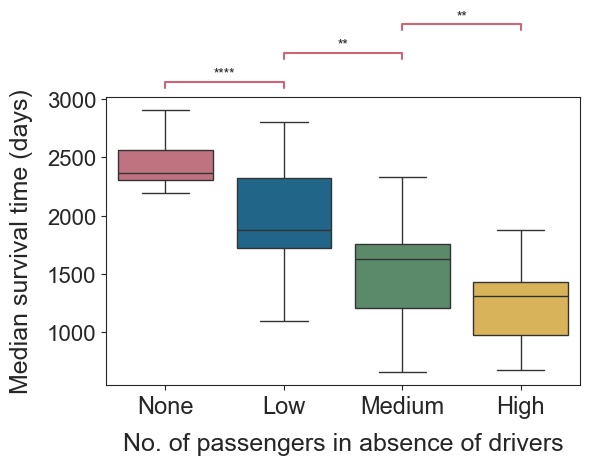

In [115]:
plt.figure(figsize=(6, 5))

# replace "Has no mutations" with "None" for better x-axis labeling
plot_data_df["group"] = plot_data_df["group"].apply(lambda x: "None" if x == "Has no mutations" else x)
order = ["None", "Low", "Medium", "High"]
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

ax = sns.boxplot(
    data=plot_data_df, 
    x='group', 
    y='median_survival',
    order=order,
    showfliers=False,
    palette=cmap
)

# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=plot_data_df, 
    x="group",
    y="median_survival", 
    pairs=[(order[0], order[1]), (order[1], order[2]), (order[2], order[3])],
    order=order,
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xticks(fontsize=17)
plt.xlabel("No. of passengers in absence of drivers", fontsize=18, labelpad=10)
plt.yticks(fontsize=16)
plt.ylabel('Median survival time (days)', fontsize=18, labelpad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/median_survival_passenger_quartiles.png", dpi=300)

# source data
plot_data_df[["median_survival", "group"]].to_csv(f"{PLOT_DATA_DIR}/median_survival_passenger_quartiles.tsv", sep="\t", index=False)

0 <5/Mb
['Drivers', 'None', 'Low', 'Medium']
1 >=5/Mb
['Low', 'High', 'Medium', 'Drivers']


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3692674572.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3692674572.py:22: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3692674572.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_97419/3692674572.py:22: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.boxplot(


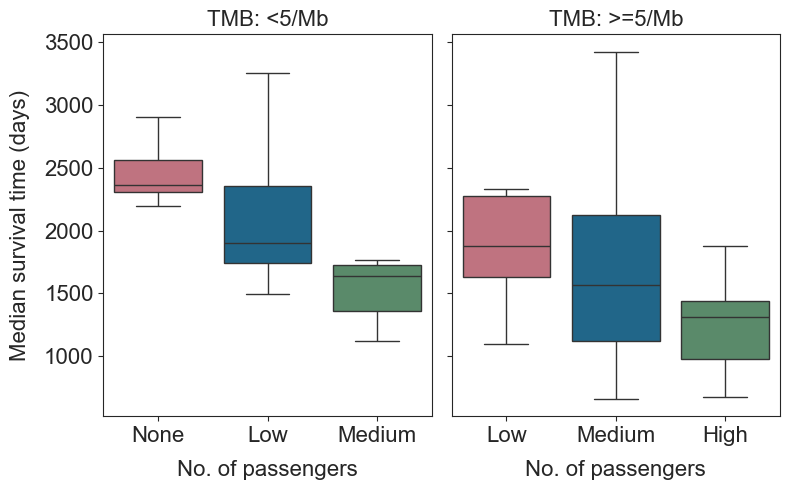

In [116]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# make median survival plots for each TMB group
tmb_groups = {
    "<5/Mb": ["Low (0-5/Mb)"],
    ">=5/Mb": ["Medium (5-10/Mb)", "High (>=10/Mb)"],
}

fig, axes = plt.subplots(1, len(tmb_groups), figsize=(len(tmb_groups)*4, 5), sharey=True)
axes = axes.flatten()

for i, tmb_group in enumerate(tmb_groups):
    print(i, tmb_group)
    plot_data_df_group = plot_data_df[plot_data_df["TMB_group"].isin(tmb_groups[tmb_group])]
    mut_groups = plot_data_df_group["group"].unique().tolist()
    print(mut_groups)
    order = [g for g in ["None", "Low", "Medium", "High"] if g in mut_groups]

    ax = sns.boxplot(
        data=plot_data_df_group, 
        x='group', 
        y='median_survival',
        order=order,
        showfliers=False,
        ax=axes[i],
        palette=cmap
    ) 

    axes[i].set_title(f"TMB: {tmb_group}", fontsize=16)
    axes[i].set_xlabel('No. of passengers', fontsize=16, labelpad=10)
    axes[i].set_ylabel('Median survival time (days)', fontsize=16, labelpad=10)
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/median_survival_passenger_quartiles_by_TMB.png", dpi=300)

# source data
plot_data_df[["median_survival", "group", "TMB_group"]].to_csv(f"{PLOT_DATA_DIR}/median_survival_passenger_quartiles_by_TMB.tsv", sep="\t", index=False)

In [117]:
# save group and median data for performing Jonckheere-Terpstra test
plot_data_df = plot_data_df[plot_data_df["group"] != "Drivers"]
plot_data_df[["group", "median_survival"]].to_csv("../results/median_survival_time_pancancer_groups.csv", index=False)